In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utilsFashionmnist import mnist
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]


In [4]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [22]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [23]:
def train(epoch, models, train_loss_plot):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        train_loss_plot[epoch-1] = [m._loss.item() for m in models]
        print(line + losses)
    return train_loss_plot


In [24]:
models = [Net(True, False)] # Pick version withpot dropout as the dropout may also lead to limit weights

In [25]:
def test(models, loader, epoch, test_loss):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    test_loss_plot[epoch-1] = test_loss[0]
    
    print(report)
    return test_loss_plot

In [30]:
epochs_number = 50
train_loss_plot = [0]*len(models)*epochs_number
test_loss_plot = [0]*len(models)*epochs_number
for epoch in range(1, epochs_number+1):
    for model in models:
        model.train()
        train_loss_plot = train(epoch, models, train_loss_plot)
    for model in models:
        model.eval()
        test_loss_plot = test(models, valid_loader, epoch,  test_loss_plot)

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 0.010358
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.072672
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.013115
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.005282
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.014649
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.013110
Test set:
0: Loss: 0.0859	Accuracy: 9748/10000 (97%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.080253
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.064209
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.076604
Train Epoch: 2 [30000/50000 (60%)]	Losses 0: 0.016952
Train Epoch: 2 [40000/50000 (80%)]	Losses 0: 0.023620
Train Epoch: 2 [50000/50000 (100%)]	Losses 0: 0.087301
Test set:
0: Loss: 0.0890	Accuracy: 9746/10000 (97%)

Train Epoch: 3 [0/50000 (0%)]	Losses 0: 0.016173
Train Epoch: 3 [10000/50000 (20%)]	Losses 0: 0.000882
Train Epoch: 3 [20000/50000 (40%)]	Losses 0: 0.015232
Train Epoch: 3 [30000/50000 (60%)]	Losses 0: 0.024413
Train Epoch: 3 [40000/50000 (80%)]	Losses

Train Epoch: 22 [50000/50000 (100%)]	Losses 0: 0.002577
Test set:
0: Loss: 0.1010	Accuracy: 9767/10000 (97%)

Train Epoch: 23 [0/50000 (0%)]	Losses 0: 0.000324
Train Epoch: 23 [10000/50000 (20%)]	Losses 0: 0.004243
Train Epoch: 23 [20000/50000 (40%)]	Losses 0: 0.000623
Train Epoch: 23 [30000/50000 (60%)]	Losses 0: 0.000172
Train Epoch: 23 [40000/50000 (80%)]	Losses 0: 0.073346
Train Epoch: 23 [50000/50000 (100%)]	Losses 0: 0.000122
Test set:
0: Loss: 0.1080	Accuracy: 9784/10000 (97%)

Train Epoch: 24 [0/50000 (0%)]	Losses 0: 0.000077
Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.000654
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.003253
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.000631
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.084985
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.009248
Test set:
0: Loss: 0.1042	Accuracy: 9776/10000 (97%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.002311
Train Epoch: 25 [10000/50000 (20%)]	Losses 0: 0.000182
Train Epoch: 25 [20000/50

Train Epoch: 44 [20000/50000 (40%)]	Losses 0: 0.000276
Train Epoch: 44 [30000/50000 (60%)]	Losses 0: 0.024699
Train Epoch: 44 [40000/50000 (80%)]	Losses 0: 0.000140
Train Epoch: 44 [50000/50000 (100%)]	Losses 0: 0.000356
Test set:
0: Loss: 0.1136	Accuracy: 9780/10000 (97%)

Train Epoch: 45 [0/50000 (0%)]	Losses 0: 0.000792
Train Epoch: 45 [10000/50000 (20%)]	Losses 0: 0.017691
Train Epoch: 45 [20000/50000 (40%)]	Losses 0: 0.027148
Train Epoch: 45 [30000/50000 (60%)]	Losses 0: 0.000494
Train Epoch: 45 [40000/50000 (80%)]	Losses 0: 0.003150
Train Epoch: 45 [50000/50000 (100%)]	Losses 0: 0.000029
Test set:
0: Loss: 0.1176	Accuracy: 9778/10000 (97%)

Train Epoch: 46 [0/50000 (0%)]	Losses 0: 0.000966
Train Epoch: 46 [10000/50000 (20%)]	Losses 0: 0.000178
Train Epoch: 46 [20000/50000 (40%)]	Losses 0: 0.000183
Train Epoch: 46 [30000/50000 (60%)]	Losses 0: 0.000040
Train Epoch: 46 [40000/50000 (80%)]	Losses 0: 0.000307
Train Epoch: 46 [50000/50000 (100%)]	Losses 0: 0.000724
Test set:
0: Loss: 

In [31]:
# некрасивый способ получить train_loss_plot в виде массивов чисел, а не массива массивов
flattened_train_list = []
for i in range(len(train_loss_plot)):
     flattened_train_list.append(train_loss_plot[i][0])

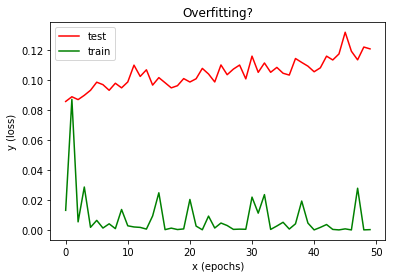

In [32]:
plt.title("Overfitting?")
plt.xlabel("x (epochs)")
plt.ylabel("y (loss)")
plt.plot(range(epochs_number), test_loss_plot, color='red', label='test')
plt.plot(range(epochs_number), flattened_train_list, color='green', label='train')
plt.legend()